In [3]:
import os
os.getcwd()

'/Users/ximengwang/DMT_assignment_2'

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from scipy.stats import pearsonr

In [6]:
# Select columns having less than 20% of missing values.
train = pd.read_csv('training_set_VU_DM.csv')
test = pd.read_csv('test_set_VU_DM.csv')

train_selected_col = train.columns[train.isnull().mean() < 0.2]
train_selected = train[train_selected_col]

train_selected.isnull().sum()
# The above sum shows that in the train_selected dataframe only the feature prop_review_score
# has 7364 missing values.

srch_id                           0
date_time                         0
site_id                           0
visitor_location_country_id       0
prop_country_id                   0
prop_id                           0
prop_starrating                   0
prop_review_score              7364
prop_brand_bool                   0
prop_location_score1              0
prop_log_historical_price         0
position                          0
price_usd                         0
promotion_flag                    0
srch_destination_id               0
srch_length_of_stay               0
srch_booking_window               0
srch_adults_count                 0
srch_children_count               0
srch_room_count                   0
srch_saturday_night_bool          0
random_bool                       0
click_bool                        0
booking_bool                      0
dtype: int64

In [9]:
# Create a dataframe containing all the samples with Null prop_review_score
review_score_null = train_selected[train_selected.prop_review_score.isnull()]

# Drop rows with NaN in 'prop_review_score' column:
train_selected_2 = train_selected.dropna()

In [22]:
# Randomly choose the same number of samples with 'click_bool == 0' as 'click_bool == 1'
train_0 = train_selected_2[train_selected_2.click_bool == 0]
train_1 = train_selected_2[train_selected_2.click_bool == 1]

print(train_0['srch_id'].count()) # 4729360
print(train_1['srch_id'].count()) # 221623

train_0 = train_0.sample(221623)
print(train_0['srch_id'].count())

train_selected_short = pd.concat([train_0,train_1])
train_selected_short = train_selected_short.sort_values(by = ['srch_id','click_bool','booking_bool'])
train_selected_short = train_selected_short.reset_index(drop=True)

4729360
221623
221623


In [23]:
# Label training data with 0,1 or 5.
train_selected_short['label'] = ""
for row in range(train_selected_short.shape[0]):
    if train_selected_short['booking_bool'].values[row] == 1:
        train_selected_short['label'].values[row] = 5
    elif train_selected_short['click_bool'].values[row] == 1:
        train_selected_short['label'].values[row] = 1
    else:
        train_selected_short['label'].values[row] = 0

train_selected_short['label'].value_counts()

0    221623
5    138274
1     83349
Name: label, dtype: int64

In [24]:
train_selected_short = train_selected_short.drop(columns =
                                                 ['random_bool','click_bool','booking_bool'])

In [17]:
# Finding common columns in training and testing sets.
train_col = train_selected_short.columns
test_col = test.columns
common_col = train_col.intersection(test_col)

In [25]:
# train_selected_short and test sets only containing common_col
label = train_selected_short.label
train_selected_short = train_selected_short[common_col]
train_selected_short = train_selected_short.assign(label = label)
test_selected = test[common_col]

In [53]:
## Define a fuction to extract year, month and day from 'date_time'
# def get_date(dataframe):
#     date_and_time = dataframe['date_time']
#     dataframe['date'] = np.zeros(len(date_and_time))
#     for num in range(len(date_and_time)):
#         dataframe.loc[num,'date'] = date_and_time[num].split()[0]
        
#     dataframe = dataframe.drop(columns='date_time')

#     date = dataframe['date']
#     dataframe['year'] = np.zeros(len(date))
#     dataframe['month'] = np.zeros(len(date))
#     dataframe['day'] = np.zeros(len(date))
#     for num in range(len(date)):
#         dataframe.loc[num,'year'] = date[num].split('-')[0]
#         dataframe.loc[num,'month'] = date[num].split('-')[1]
#         dataframe.loc[num,'day'] = date[num].split('-')[2]
        
#     dataframe = dataframe.drop(columns='date')

#     dataframe['year'] = [int(i) for i in dataframe['year']]
#     dataframe['month'] = [int(i) for i in dataframe['month']]
#     dataframe['day'] = [int(i) for i in dataframe['day']]

In [65]:
# Heatmap to illustrate correlations between features/columns
train_selected_short = train_selected_short.drop(columns='date_time')
test_selected = test_selected.drop(columns='date_time')

In [77]:
# Calculating correlations between features/columns in training set
columns = ['prop_starrating', 'prop_review_score',
       'prop_location_score1', 'prop_log_historical_price', 'price_usd',
       'promotion_flag', 'srch_destination_id', 'srch_length_of_stay',
       'srch_booking_window', 'srch_adults_count', 'srch_children_count',
       'srch_room_count']
nColumns = len(columns)
pearson_r = pd.DataFrame(np.zeros((nColumns,nColumns)), columns = columns)
for row_num in range(nColumns):
    for col_num in range(nColumns):
        pearson_r.iloc[row_num,col_num] = pearsonr(train_selected_short.loc[:,columns[row_num]],
                                                    train_selected_short.loc[:,columns[col_num]])[0]

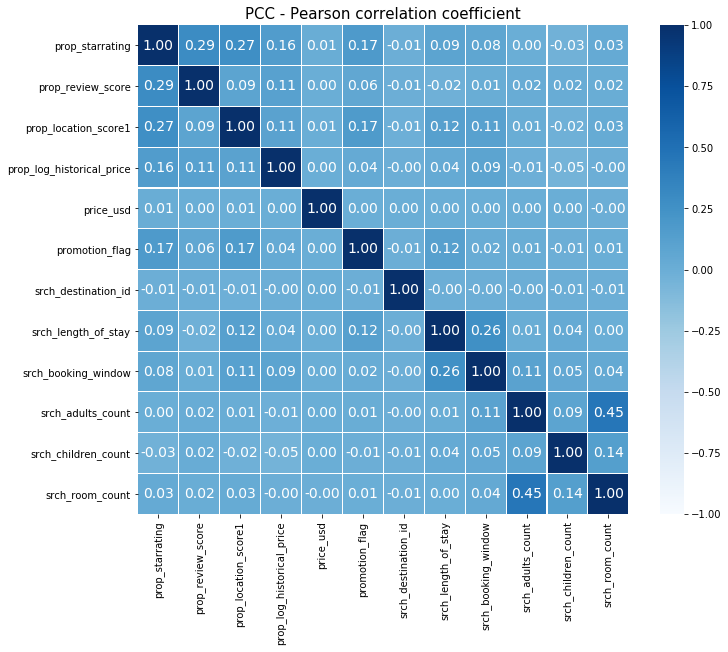

In [86]:
# Heatmap to illustrate correlations between features/columns in training set
ax = plt.figure(figsize=(11,9))
ax = sns.heatmap(pearson_r, yticklabels=columns, vmin=-1, vmax=1,
                 annot=True, fmt='.2f', linewidths=.1,cmap="Blues",
                 annot_kws={"size": 14, "color": 'white'})
ax.set_xticklabels(ax.get_xmajorticklabels(),fontsize = 10)
ax.set_yticklabels(ax.get_ymajorticklabels(),fontsize = 10)
ax.set_title('PCC - Pearson correlation coefficient', fontsize = 15)
# fig = ax.get_figure()
# fig.savefig("correlation_heatmap.png")
plt.show()

In [87]:
# combine 'srch_adults_count' and 'srch_children_count' into 'people_count'
# and check its correlation with 'srch_room_count'.
people_count = train_selected_short.srch_adults_count + train_selected_short.srch_children_count
room_count = train_selected_short.srch_room_count
r_people_room = pearsonr(people_count,room_count)[0]
print(r_people_room) # 0.42

0.417737737855744


In [88]:
# Export the training and test sets
train_selected_short.to_csv("train_processed.csv", index=False)
test_selected.to_csv("test_processed.csv", index=False)